In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrow

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
# pth_out = os.path.join(pth, 'figures', 'modeling')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'CCCA_malignant.h5ad'))
adata

AnnData object with n_obs × n_vars = 1434229 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores', 'post_op_gleason_score', 'margin

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# average score, module attributions ()
src_train = df.loc[df.Training == True].index
# msk = adata.obs.source.isin(src_train) & (adata.obs.trajectory == 'True')
grp = adata.obs.groupby('Disease')
z = grp.latent_z.mean().sort_values(ascending = False)#.loc[grp.size() > 200]
attr = grp[src_train].mean().loc[z.index]

/tmp/ipykernel_3877794/2728608866.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = adata.obs.groupby('Disease')


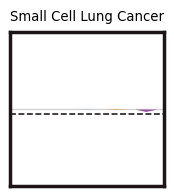

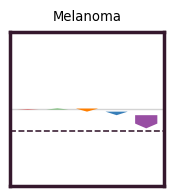

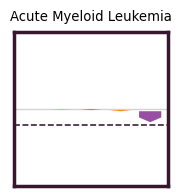

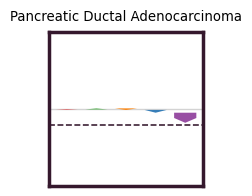

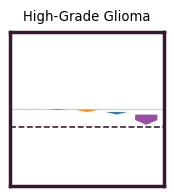

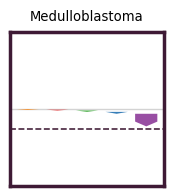

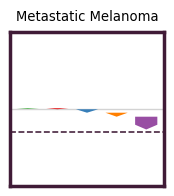

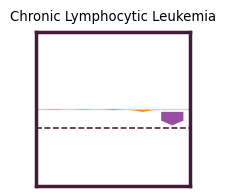

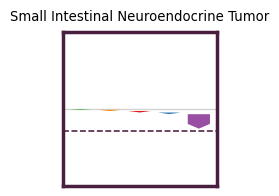

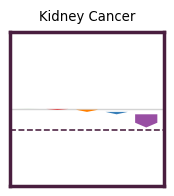

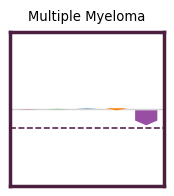

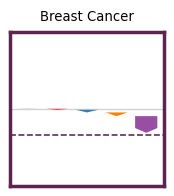

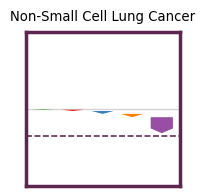

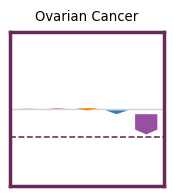

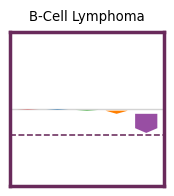

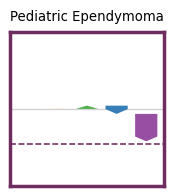

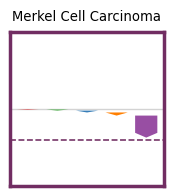

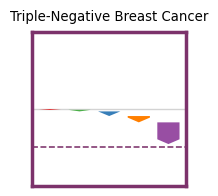

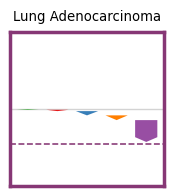

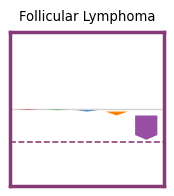

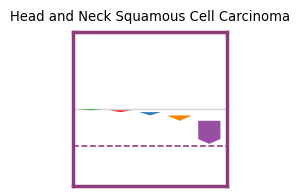

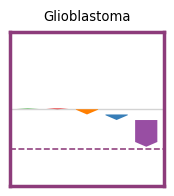

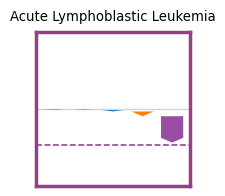

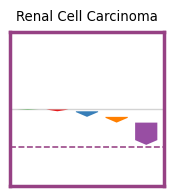

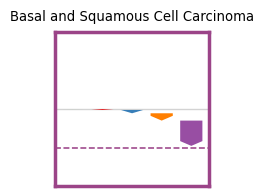

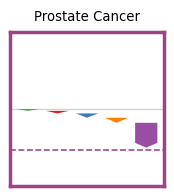

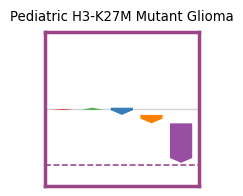

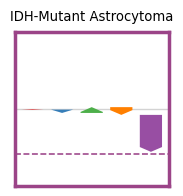

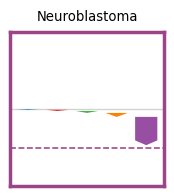

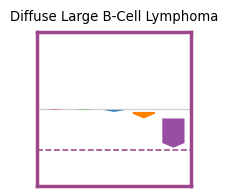

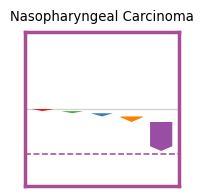

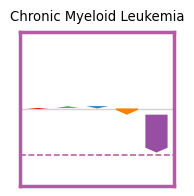

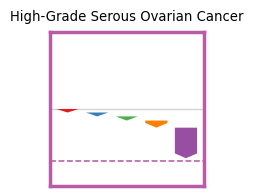

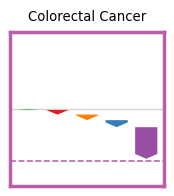

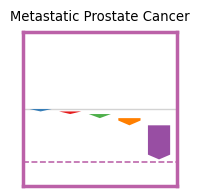

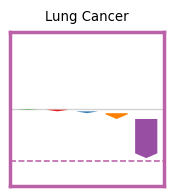

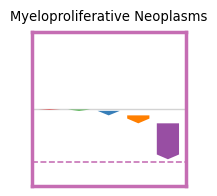

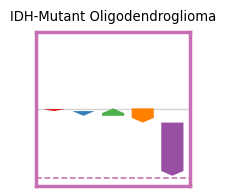

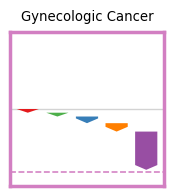

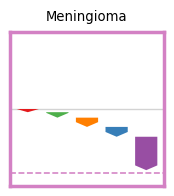

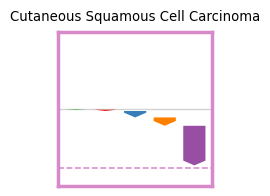

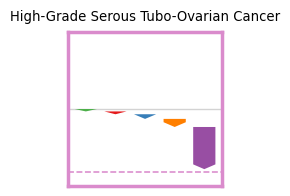

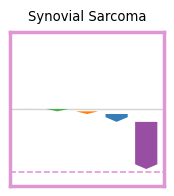

In [7]:
# waterfall plots
wbar, hlen, pad, cmap = .75, .035, [.6, .075], plt.cm.Set1
colors = {col : cmap(i) for i, col in enumerate(attr.columns)}
xlim = (-pad[0], attr.shape[1] - 1 + pad[0])
ylim = attr.sum(axis = 1).abs().max() + pad[1]

# plot grid
fs1, fs2, cmap_z = 9.5, 10.5, plt.cm.vanimo
# fig, ax = plt.subplots(1, attr.shape[0], figsize = (25, 5))
for i, ix in enumerate(attr.index):
    plt.figure(figsize = (2, 2))
    attr_i = attr.loc[ix].sort_values(key = abs)
    heads = attr_i.cumsum().to_numpy()
    tails = np.concat(([0], heads[:-1]))
    colors_i = attr_i.index.map(colors)
    color_zi = cmap_z(z.loc[ix])
  
    # plot bars
    for j in range(heads.size):
        dy = heads[j] - tails[j]
        head_length = min(abs(dy), hlen)
        arrow = FancyArrow(
            x = j,
            y = tails[j],
            dx = 0,
            dy = dy,
            width = wbar,
            head_width = wbar,
            head_length = head_length,
            length_includes_head = True,
            linewidth = 0,
            color = colors_i[j])
        plt.gca().add_artist(arrow)

    # zero attribution
    plt.axhline(0,
                  color = 'lightgray',
                  linewidth = 1,
                  zorder = 0)
    
    # total attribution
    plt.axhline(heads[j] + .0185 * np.sign(dy),
                  color = color_zi,
                  linestyle = '--',
                  linewidth = 1.15,
                  zorder = 0)
    
    # average score
    for sp in plt.gca().spines.values():
        sp.set_color(color_zi)
        sp.set_linewidth(2.5)

    plt.gca().set_title(ix, size = fs1, pad = 8)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().set_xlim(xlim)
    plt.gca().set_ylim(-ylim, ylim)
    plt.gca().set_box_aspect(1)

    plt.show()

# for i in (7, 10):
#     title = ax[i].get_title().replace(' ', '\n', 1)
#     ax[i].set_title(title, size = fs1)

# ax[0].set_ylabel('Module Attribution',
#                  size = fs2, labelpad = 7)

# # legend
# handles = [Patch(facecolor = val, label = df.loc[key].Name)
#            for key, val in colors.items()]
# ax[5].legend(handles = handles,
#              loc = 'center',
#              fontsize = fs1 + .5,
#              frameon = False,
#              ncol = len(handles),
#              bbox_to_anchor = (.5, -.175))

# fn = os.path.join(pth_out, 'attributions.pdf')
# plt.savefig(fn, bbox_inches = 'tight')